# Exercise 6: Multi-Step Bootstrapping

In this exercise we will have a look at n-step methods and eligibility trace. The n-step methods are a class of reinforcement learning algorithms that are an abstraction of the Monte Carlo and TD(0) methods discussed earlier and include them as special cases. Furthermore, we also consider the eligibility traces, which take a reverse approach to determining the state values. The environment we will be dealing with is a little more typical for control research: the inverted pendulum. 

![](https://miro.medium.com/max/1000/1*TNo3x9zDi1lVOH_3ncG7Aw.gif)

To implement this environment, we will make use of the gymnasium library. Please install the gymnasium library within your preferred Python environment using:

```pip install gymnasium```

In [1]:
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Check if the installation and import work by executing the following cell. A window with an animation of the pendulum should open, display some random actions, and close automatically.

In [2]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped # removes a built-in time limit of k_T = 200, we want to determine the time limit ourselves

state, _ = env.reset()
for _ in range(300):
    # env.render()
    state, reward, terminated, _, _ = env.step(env.action_space.sample()) # take a random action
env.close()

The goal of this environment is to bring the pendulum into the upper neutral position, where the angle $\theta = 0$ and the angular velocitiy $\frac{\text{d}}{\text{d}t}\theta=\omega=0$. The reward function is already designed that way and does not need further specification. For further information about the environment you may refer to the code and documentation of Farama Foundation's `gymnasium`:

[Documentation of the gymnasium pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/)

[Pendulum environment in the gymnasium Github repository](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py)

## 1) Discretization of Action and State Space

Unlike the racetrack environment, the inverted pendulum comes with a continuous action and state space. Although it is possible to handle systems with these characteristics, we did not yet learn how to deal with them. For now, we only know how to implement agents for discrete action and state spaces. Accordingly, we will also try to represent the inverted pendulum within a discrete state / action space. For this, a discretization is necessary.

The pendulum has three state variables relating to the momentary angular position $\theta$:
\begin{align*}
    x=\begin{bmatrix}
    \text{cos}(\theta)\\
    \text{sin}(\theta)\\
    \frac{\text{d}}{\text{d}t}\theta
    \end{bmatrix}
    \in
    \begin{bmatrix}
    [-1, 1]\\
    [-1, 1]\\
    [-8 \, \frac{1}{\text{s}}, 8 \, \frac{1}{\text{s}}]
    \end{bmatrix},
\end{align*}

and one input variable which relates to the torque applied at the axis of rotation:

$u = T \in [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]$

After the discretization, we want the system to be defined on sets of non-negative natural numbers:

\begin{align*}
    x_d =
    \text{discretize_state}(x)
    \in
    \begin{bmatrix}
    \{0,1,2,...,d_{\theta}-1\}\\
    \{0,1,2,...,d_{\theta}-1\}\\
    \{0,1,2,...,d_{\omega}-1\}
    \end{bmatrix},
\end{align*}

$
u_d =
\text{discretize_action}(u)
\in
\{0,1,2,...,d_{T}-1\}.
$

Since action is selected within the discrete action space, we need to transform it accordingly:

$
u=
\text{continualize_action}(u_d):
\{0,1,2,...,d_{T}-1\} \rightarrow [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]
.
$

Write the functions `discretize_state` and `continualize_action`, such that a discrete RL agent can be applied. (Please note that all I/O of `gymnasium` consists of numpy arrays.) Write the functions in such a way that the number of discretization intervals $d_\theta, d_\omega, d_T$ are parameters that can be changed for different tests. The discretization intervals should be uniformly distributed on their respective state space.

A parametrization of $d_\theta = d_\omega = d_T = 15$ can be used to yield satisfactory results in this exercise.
However, does it make a difference if the number of discretization intervals is odd or even? If yes, what should be preferred for the given environment? 

## Solution 1)

Code given below.

The number of discretization intervals can in fact make a difference in this case. The inverted pendulum can be considered as solved when brought into the upper neutral position $\theta=0, \omega=0$. The state as given by `gymnasium` would therefore be:

\begin{align*}
x_\text{neutral}=
\begin{bmatrix}
\text{cos}(0)\\
\text{sin}(0)\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix},
u_\text{neutral}=0
\end{align*}

Consequently, the discretization / continualization should allow for precise transformation of this state, which is given when assuming an odd number of discretization intervals. If one uses an even number of intervals, one interval boundary will be located exactly at zero, potentially leading to rapid bouncing around the neutral position.

In [3]:
d_T = 15
d_theta = 15
d_omega = 15


def discretize_state(states):

    ### BEGIN SOLUTION

    limits = [1, 1, 8]
    nb_disc_intervals = [d_theta, d_theta, d_omega]

    q_intervals = [np.linspace(-l, l, i+1)
                   for l, i in zip(limits, nb_disc_intervals)]
    # Clipping is necessary due to linspacing with an additional interval, which in turn is necessary
    #  for how numpy.digitize works (i.e., it floors the continuous value)
    return np.array([np.digitize(s, q).clip(max=q.size - 1) - 1 for s, q in zip(states, q_intervals)],
                    dtype=int)  # int is necessary for indexing
    ### END SOLUTION


def continualize_action(disc_action):

    ### BEGIN SOLUTION

    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()

    ### END SOLUTION


Use the following cell for debugging:

In [4]:
env = gym.make('Pendulum-v1', render_mode="human")
state, _ = env.reset()
for _ in range(5):
    disc_action = np.random.choice(range(9))
    cont_action = continualize_action(disc_action)
    print("discrete action: {}, continuous action: {}".format(disc_action, cont_action))
    
    state, reward, terminated, _, _ = env.step(cont_action) # take a random action
    disc_state = discretize_state(state)
    print("discrete state: {}, continuous state: {}".format(disc_state, state))
    
env.close()

discrete action: 7, continuous action: [0.]
discrete state: [14  4  6], continuous state: [ 0.91508424 -0.4032627  -0.62496334]
discrete action: 6, continuous action: [-0.28571429]
discrete state: [14  4  6], continuous state: [ 0.8944517  -0.44716465 -0.97026753]
discrete action: 1, continuous action: [-1.71428571]
discrete state: [13  3  6], continuous state: [ 0.8568169 -0.5156208 -1.5627838]
discrete action: 0, continuous action: [-2.]
discrete state: [13  2  5], continuous state: [ 0.7935307 -0.6085302 -2.2494996]
discrete action: 1, continuous action: [-1.71428571]
discrete state: [12  2  4], continuous state: [ 0.6950125  -0.71899766 -2.96304   ]


c:\Users\marmey\Documents\reinforcement_learning_course_materials\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Discretization Diagrams

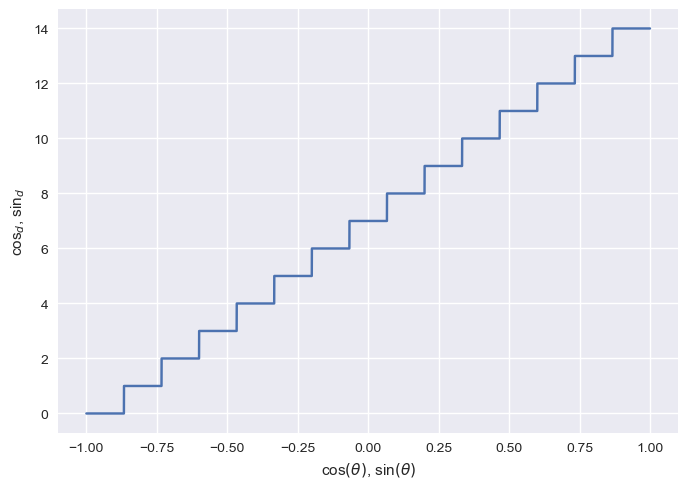

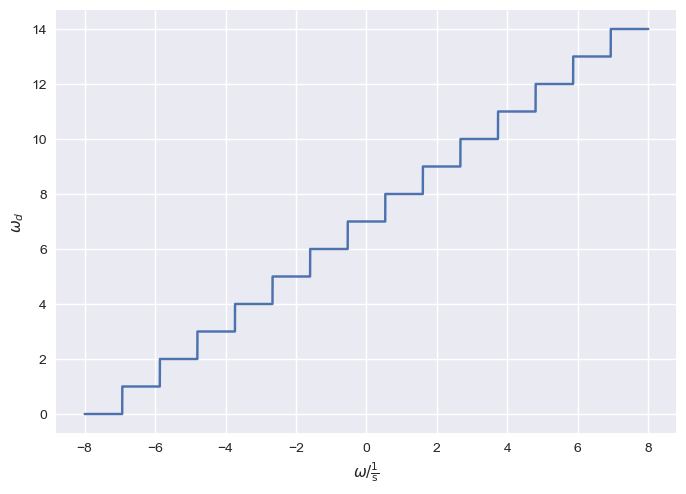

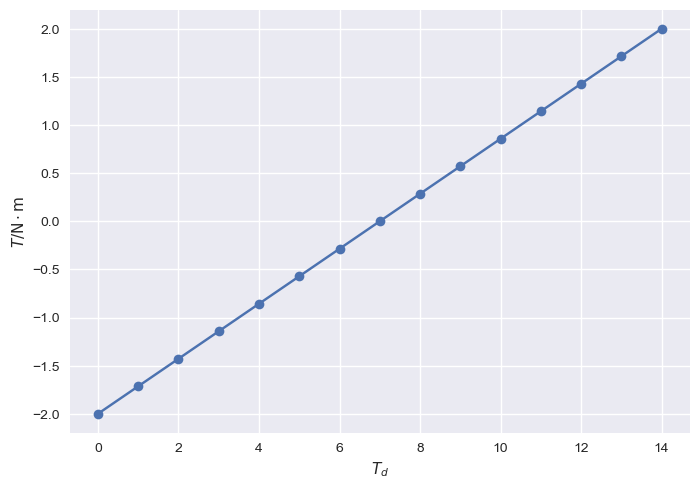

In [5]:
cos_theta = np.linspace(-1, 1, 10000)
sin_theta = np.linspace(-1, 1, 10000)
omega = np.linspace(-8, 8, 10000)
T = np.arange(0, d_T, 1)

disc_states = np.array([discretize_state(np.array([c, s, o])) for c, s, o in zip(cos_theta, sin_theta, omega)])
cont_actions = [continualize_action(np.array(t)) for t in T]

plt.plot(cos_theta, disc_states[:, 0])
plt.xlabel(r"cos$(\theta)$, sin$(\theta)$")
plt.ylabel(r"cos${}_d$, sin${}_d$")
plt.grid('major')
plt.show()
plt.plot(omega, disc_states[:, 2])
plt.xlabel(r"$\omega / \frac{1}{\mathrm{s}}$")
plt.ylabel(r"$\omega_d$")
plt.grid('major')
plt.show()
plt.plot(T, cont_actions, 'o-')
plt.xlabel(r"$T_d$")
plt.ylabel(r"$T / \mathrm{N} \cdot \mathrm{m}$")
plt.grid('major')
plt.show()

## 2) n-Step Sarsa

Write an on-policy n-step Sarsa control algorithm for the inverted pendulum from scratch. This time, no code template is given. 

Use the following parameters: $\alpha=0.1, \gamma=0.9, \varepsilon=0.1, n=10$ with 500 time steps in 2000 episodes.

![](nStepSARSA_Algo.png)

## Solution 2)

Execution might take long due to the "render" command, but this allows to observe the learning. Comment out to execute faster.

In [6]:
env = gym.make('Pendulum-v1') # , render_mode="human"
env = env.unwrapped

alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # epsilon greedy parameter
n = 10  # steps between updates

nb_episodes = 2000  # number of episodes
nb_steps = 500  # length of episodes

action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
# int is necessary for indexing
pi = np.zeros([d_theta, d_theta, d_omega], dtype=int)

# we can use this to figure out how well the learning worked
cumulative_reward_history = []

for j in tqdm(range(nb_episodes), position=0, leave=True):

    ### BEGIN SOLUTION

    states = []
    actions = []
    rewards = []

    state, _ = env.reset()  # initialize x_0
    terminated = False
    # terminal time (not actually needed for the pendulum, but we want to keep it general)
    k_T = None

    # will be multiplied with the last rewards
    discount_array = gamma ** np.arange(n)

    disc_state = tuple(discretize_state(state))  # use tuple indexing

    disc_action = pi[disc_state]

    states.append(disc_state)
    actions.append(tuple([disc_action]))

    for k in range(nb_steps + n - 2):

        if not terminated:
            cont_action = continualize_action(disc_action)
            # env.render() # comment out for faster execution
            state, reward, terminated, _, _ = env.step(cont_action)

            disc_state = tuple(discretize_state(state))

            states.append(disc_state)
            rewards.append(reward)

        if not terminated:  # was already checked before step but has to be checked again after step
            if np.random.uniform(0, 1) < epsilon:
                disc_action = np.random.choice(d_T)  # explorative action
            else:
                disc_action = pi[disc_state]  # exploitative action

            actions.append(tuple([disc_action]))

        elif k_T == None:  # if necessary, set terminal time
            k_T = k

        tau = k - n + 1

        if tau >= 0:  # test if agent waited long enough to learn
            if terminated:
                # helps eliminate contemplation of rewards after termination
                rewards.append(0)
            last_rewards = rewards[-n:]
            g = (discount_array * last_rewards).sum()
            if not terminated:
                g += gamma ** n * action_values[states[k+1] + actions[k+1]]

            tau_state = states[tau]
            action_values[tau_state + actions[tau]] += alpha * \
                (g - action_values[tau_state + actions[tau]])
            pi[tau_state] = np.argmax(action_values[tau_state])

        if tau + 1 == k_T:
            break

    cumulative_reward_history.append(np.sum(rewards))

env.close()


### END SOLUTION
pi_learned = np.copy(pi)  # save pi in cache under different name for later


  0%|          | 0/2000 [00:00<?, ?it/s]

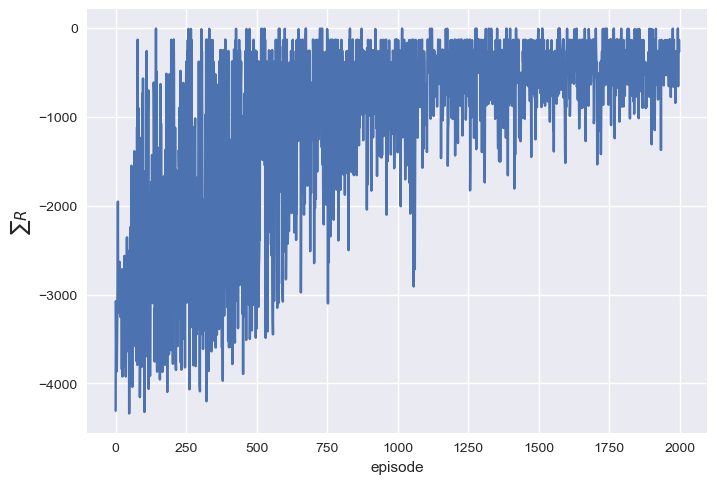

(2000,)


In [7]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [8]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped

nb_steps = 200

state, _ = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state)) # use tuple indexing
disc_action = pi_learned[disc_state]

for k in range(nb_steps):
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, terminated, _, _ = env.step(cont_action)
    disc_state = tuple(discretize_state(state))
        
    if terminated:
        break
        
    disc_action = pi_learned[disc_state] # exploitative action
    
env.close()

## 3) Recursive updates: TD($\lambda$) 

Both, $n$-step and $\lambda$-return updates, are based on a forward view. That means we have to wait for future states and rewards before an update can be performed.
We therefore introduce an eligibility traces, which follows the general idea that previous actions have significantly led to the current situation. Contrary to n-step learning, however, intuition tells us that more recent decisions had a more severe impact on the present situation than decisions that were made a long time ago. Thus, it may be helpful to integrate a forgetting factor $\lambda$ which decreases the assumed influence of actions over time.

Solution 2 is now to be extended by eligibility traces $z_k(x_k)$ within the action-value update. Test it for different values of $\lambda$. How sensitive is the process to the choice of $\lambda$?

In [9]:
env = gym.make('Pendulum-v1') # , render_mode="human"
env = env.unwrapped

alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # epsilon greedy parameter
n = 1  # steps between updates
lamb = 0.9  # forgetting factor

nb_episodes = 5000  # number of episodes
nb_steps = 500  # length of episodes

action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
# init eligibility trace
eligibility = np.zeros([d_theta, d_theta, d_omega])
# int is necessary for indexing
pi = np.zeros([d_theta, d_theta, d_omega], dtype=int)

# we can use this to figure out how well the learning worked
cumulative_reward_history = []

for j in tqdm(range(nb_episodes), position=0, leave=True):

    ### BEGIN SOLUTION

    states = []
    actions = []
    rewards = []

    state, _ = env.reset()  # initialize x_0
    terminated = False
    # terminal time (not actually needed for the pendulum, but we want to keep it general)
    k_T = None

    # will be multiplied with the last rewards
    discount_array = gamma ** np.arange(n)

    disc_state = tuple(discretize_state(state))  # use tuple indexing

    # update eligibilities
    eligibility *= lamb * gamma
    eligibility[disc_state] += 1.0

    disc_action = pi[disc_state]

    states.append(disc_state)
    actions.append(tuple([disc_action]))

    for k in range(nb_steps + n - 2):

        if not terminated:
            cont_action = continualize_action(disc_action)
            # env.render() # comment out for faster execution
            state, reward, terminated, _, _ = env.step(cont_action)

            disc_state = tuple(discretize_state(state))

            # update eligibilities
            eligibility *= lamb * gamma
            eligibility[disc_state] += 1.0

            states.append(disc_state)
            rewards.append(reward)

        if not terminated:  # was already checked before step but has to be checked again after step
            if np.random.uniform(0, 1) < epsilon:
                disc_action = np.random.choice(d_T)  # explorative action
            else:
                disc_action = pi[disc_state]  # exploitative action

            actions.append(tuple([disc_action]))

        elif k_T == None:  # if necessary, set terminal time
            k_T = k

        tau = k - n + 1

        if tau >= 0:  # test if agent waited long enough to learn
            if terminated:
                # helps eliminate contemplation of rewards after termination
                rewards.append(0)
            last_rewards = rewards[-n:]
            g = (discount_array * last_rewards).sum()
            if not terminated:
                g += gamma ** n * action_values[states[k+1] + actions[k+1]]

            tau_state = states[tau]
            action_values[tau_state + actions[tau]] += alpha * \
                (g - action_values[tau_state + actions[tau]]) * eligibility[tau_state]
            pi[tau_state] = np.argmax(action_values[tau_state])

        if tau + 1 == k_T:
            break

    cumulative_reward_history.append(np.sum(rewards))

env.close()


### END SOLUTION

  0%|          | 0/5000 [00:00<?, ?it/s]

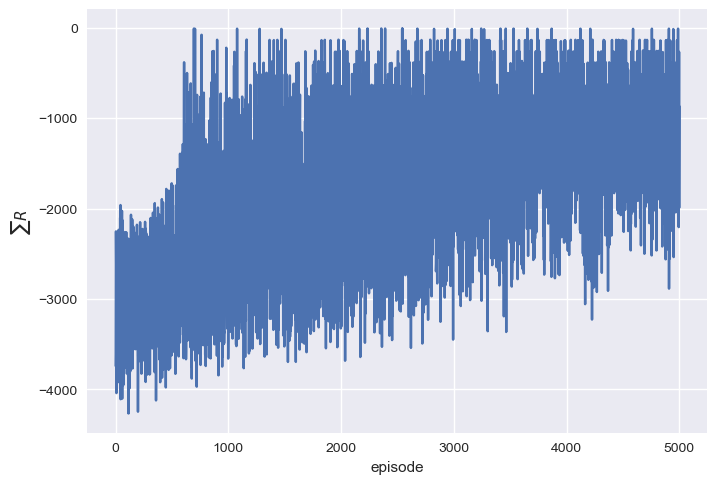

(5000,)


In [10]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [11]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped

nb_steps = 200

state, _ = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state)) # use tuple indexing
disc_action = pi[disc_state]

for k in range(nb_steps):
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, terminated, _, _ = env.step(cont_action)
    disc_state = tuple(discretize_state(state))
        
    if terminated:
        break
        
    disc_action = pi[disc_state] # exploitative action
    
env.close()